In [1]:
import os
import joblib
from tqdm import tqdm
from IPython.display import Image, display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchinfo import summary
from torchviz import make_dot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Transformer

### Data Importing

In [3]:
df = pd.read_csv("./.data/train_aug.csv")

In [4]:
print(df)

               id   bg-1:55   bg-1:50   bg-1:45   bg-1:40   bg-1:35   bg-1:30  \
0           p01_0  3.103256  3.207739  3.306019  3.338826  3.354246  3.385527   
1           p01_1  3.334344  3.368640  3.382463  3.342868  3.303760  3.241867   
2           p01_2  3.351738  3.290329  3.235490  3.198546  3.087441  2.998913   
3           p01_3  3.164014  3.096026  3.013504  3.049034  3.062024  3.092045   
4           p01_4  3.036686  3.041001  3.069754  3.055564  3.022660  2.999762   
...           ...       ...       ...       ...       ...       ...       ...   
354043  p12_25294 -0.143842 -0.166453 -0.178820 -0.190547 -0.300671 -0.393663   
354044  p12_25295 -0.173634 -0.161785 -0.186081 -0.298534 -0.412794 -0.461140   
354045  p12_25296 -0.205563 -0.200199 -0.298250 -0.389232 -0.461662 -0.512562   
354046  p12_25297 -0.188150 -0.278181 -0.400960 -0.453957 -0.532632 -0.628098   
354047  p12_25298 -0.291531 -0.394955 -0.461099 -0.537074 -0.637675 -0.692059   

         bg-1:25   bg-1:20 

In [5]:
for col in df.columns:
    print(col)

id
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-1:55
insulin-1:50
insulin-1:45
insulin-1:40
insulin-1:35
insulin-1:30
insulin-1:25
insulin-1:20
insulin-1:15
insulin-1:10
insulin-1:05
insulin-1:00
insulin-0:55
insulin-0:50
insulin-0:45
insulin-0:40
insulin-0:35
insulin-0:30
insulin-0:25
insulin-0:20
insulin-0:15
insulin-0:10
insulin-0:05
insulin-0:00
carbs-1:55
carbs-1:50
carbs-1:45
carbs-1:40
carbs-1:35
carbs-1:30
carbs-1:25
carbs-1:20
carbs-1:15
carbs-1:10
carbs-1:05
carbs-1:00
carbs-0:55
carbs-0:50
carbs-0:45
carbs-0:40
carbs-0:35
carbs-0:30
carbs-0:25
carbs-0:20
carbs-0:15
carbs-0:10
carbs-0:05
carbs-0:00
hr-1:55
hr-1:50
hr-1:45
hr-1:40
hr-1:35
hr-1:30
hr-1:25
hr-1:20
hr-1:15
hr-1:10
hr-1:05
hr-1:00
hr-0:55
hr-0:50
hr-0:45
hr-0:40
hr-0:35
hr-0:30
hr-0:25
hr-0:20
hr-0:15
hr-0:10
hr-0:05
hr-0:00
steps-1:55
steps-1:50
steps-1:45
step

### Data Splitting

In [6]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [7]:
print(f"Train Shape: {train_df.shape}")
print(f"Validation Shape: {val_df.shape}")
print(f"Test Shape: {test_df.shape}")

Train Shape: (283238, 146)
Validation Shape: (35405, 146)
Test Shape: (35405, 146)


### Dataset and DataLoader

In [8]:
class BrisT1DDataset(Dataset):
    def __init__(self, df, is_train=True):
        
        self.df = df
        self.is_train = is_train
        
        if 'id' in self.df.columns:
            self.ids = self.df['id'].values
            self.df = self.df.drop(columns=['id'])
        else:
            self.ids = None
        
        if self.is_train and 'bg+1:00' in self.df.columns:
            self.targets = self.df['bg+1:00'].values
            self.df = self.df.drop(columns=['bg+1:00'])
        else:
            self.targets = None
        
        data = self.df.values.astype(np.float32)
        if data.shape[1] != 144:
            raise ValueError(f"Expected 144, Real {data.shape[1]}")
        self.X = data.reshape(-1, 6, 24).transpose(0, 2, 1)
        
        if self.is_train:
            self.y = self.targets.astype(np.float32).reshape(-1, 1)
        else:
            self.y = None

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        sample = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.is_train:
            target = torch.tensor(self.y[idx], dtype=torch.float32)
            return sample, target
        else:
            return sample

In [9]:
train_dataset = BrisT1DDataset(train_df, is_train=True)
val_dataset = BrisT1DDataset(val_df, is_train=True)
test_dataset = BrisT1DDataset(test_df, is_train=True)

In [10]:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model

In [11]:
class BrisT1DDPositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.25, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [12]:
class BrisT1DDTransformer(nn.Module):
    def __init__(self, num_features=6, d_model=64, nhead=8, num_layers=2, dropout=0.25, seq_length=24):
        super().__init__()
        self.input_projection = nn.Linear(num_features, d_model)
        self.positional_encoding = BrisT1DDPositionalEncoding(d_model, dropout, max_len=seq_length)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(d_model, 1)
        
    def forward(self, x):
        x = self.input_projection(x)            
        x = self.positional_encoding(x)           
        x = self.transformer_encoder(x)           
        x = x.mean(dim=1)                        
        x = self.dropout(x)
        out = self.fc(x)                        
        return out

In [13]:
model = BrisT1DDTransformer(num_features=6, d_model=64, nhead=8, num_layers=2,
                            dropout=0.25, seq_length=24).to(device)
print(model)

BrisT1DDTransformer(
  (input_projection): Linear(in_features=6, out_features=64, bias=True)
  (positional_encoding): BrisT1DDPositionalEncoding(
    (dropout): Dropout(p=0.25, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.25, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.25, inplace=False)
        (dropout2): Dropout(p=0.25, inplace=False)
      )
    )
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=64, out_features=

#### Model Summary

In [14]:
dummy_seq = torch.randn(1, 24, 6).to(device)

In [15]:
print("Model Summary:")
print(summary(model, input_data=[dummy_seq]))

Model Summary:
Layer (type:depth-idx)                        Output Shape              Param #
BrisT1DDTransformer                           [1, 1]                    --
├─Linear: 1-1                                 [1, 24, 64]               448
├─BrisT1DDPositionalEncoding: 1-2             [1, 24, 64]               --
│    └─Dropout: 2-1                           [1, 24, 64]               --
├─TransformerEncoder: 1-3                     [1, 24, 64]               --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 24, 64]               281,152
│    │    └─TransformerEncoderLayer: 3-2      [1, 24, 64]               281,152
├─Dropout: 1-4                                [1, 64]                   --
├─Linear: 1-5                                 [1, 1]                    65
Total params: 562,817
Trainable params: 562,817
Non-trainable params: 0
Total mult-adds (M): 0.53
Input size (MB): 0.00
Forward/backward pass si

#### Model Computational Graph

In [16]:
dummy_output = model(dummy_seq)
dot = make_dot(dummy_output, params=dict(model.named_parameters()))

Model Computational Graph:


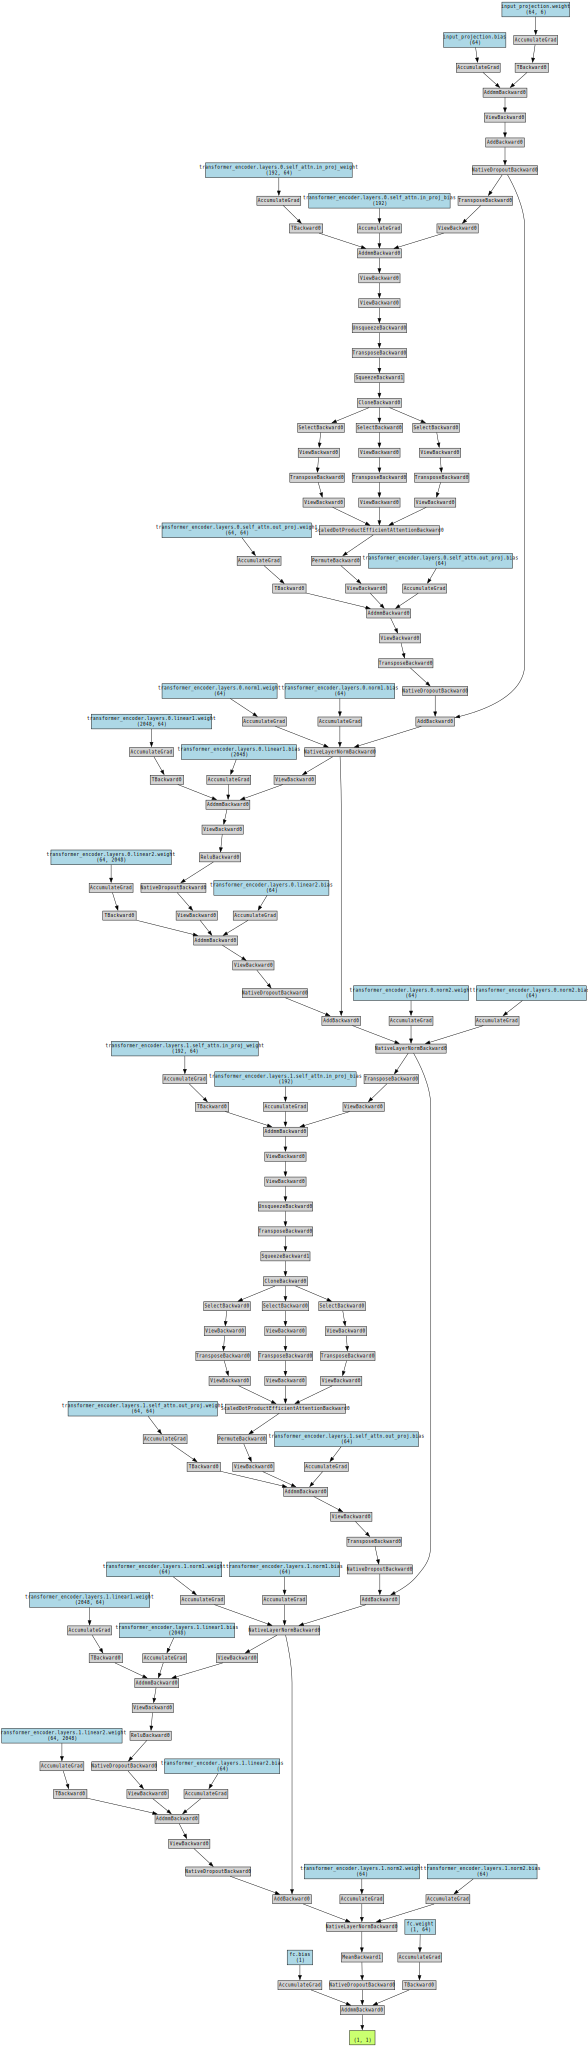

In [17]:
print("Model Computational Graph:")
display(dot)

### Training

In [18]:
epochs = 100
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
patience = 10

In [19]:
train_losses = []
val_losses = []
best_val_loss = float("inf")
epochs_no_improve = 0

In [20]:
train_losses = []
val_losses = []
best_val_loss = float("inf")
epochs_no_improve = 0

for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    # Training
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * X_batch.size(0)
        
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False):
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            running_val_loss += loss.item() * X_val.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch: {epoch+1}/{epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), './.export/checkpoint-aug-tf.pt')
    else:
        epochs_no_improve += 1
        print(f"Early Stopping: {epochs_no_improve}/{patience}")
        
    if epochs_no_improve >= patience:
        print("Early Stopping!")
        break

Epoch: 1/100 | Train Loss: 0.5479 | Val Loss: 0.4767


Epoch: 2/100 | Train Loss: 0.4828 | Val Loss: 0.4566


Epoch: 3/100 | Train Loss: 0.4710 | Val Loss: 0.4378


Epoch: 4/100 | Train Loss: 0.4629 | Val Loss: 0.4863
Early Stopping: 1/10


Epoch: 5/100 | Train Loss: 0.4568 | Val Loss: 0.4603
Early Stopping: 2/10


Epoch: 6/100 | Train Loss: 0.4509 | Val Loss: 0.4291


Epoch: 7/100 | Train Loss: 0.4478 | Val Loss: 0.4180


Epoch: 8/100 | Train Loss: 0.4419 | Val Loss: 0.4190
Early Stopping: 1/10


Epoch: 9/100 | Train Loss: 0.4375 | Val Loss: 0.4128


Epoch: 10/100 | Train Loss: 0.4331 | Val Loss: 0.4217
Early Stopping: 1/10


Epoch: 11/100 | Train Loss: 0.4296 | Val Loss: 0.4151
Early Stopping: 2/10


Epoch: 12/100 | Train Loss: 0.4251 | Val Loss: 0.4262
Early Stopping: 3/10


Epoch: 13/100 | Train Loss: 0.4206 | Val Loss: 0.4080


Epoch: 14/100 | Train Loss: 0.4165 | Val Loss: 0.4077


Epoch: 15/100 | Train Loss: 0.4137 | Val Loss: 0.4295
Early Stopping: 1/10


Epoch: 16/100 | Train Loss: 0.4077 | Val Loss: 0.4130
Early Stopping: 2/10


Epoch: 17/100 | Train Loss: 0.4045 | Val Loss: 0.4071


Epoch: 18/100 | Train Loss: 0.3995 | Val Loss: 0.3939


Epoch: 19/100 | Train Loss: 0.3939 | Val Loss: 0.3838


Epoch: 20/100 | Train Loss: 0.3896 | Val Loss: 0.3827


Epoch: 21/100 | Train Loss: 0.3846 | Val Loss: 0.3900
Early Stopping: 1/10


Epoch: 22/100 | Train Loss: 0.3811 | Val Loss: 0.3892
Early Stopping: 2/10


Epoch: 23/100 | Train Loss: 0.3749 | Val Loss: 0.3749


Epoch: 24/100 | Train Loss: 0.3687 | Val Loss: 0.3850
Early Stopping: 1/10


Epoch: 25/100 | Train Loss: 0.3640 | Val Loss: 0.3769
Early Stopping: 2/10


Epoch: 26/100 | Train Loss: 0.3585 | Val Loss: 0.3713


Epoch: 27/100 | Train Loss: 0.3548 | Val Loss: 0.3801
Early Stopping: 1/10


Epoch: 28/100 | Train Loss: 0.3489 | Val Loss: 0.3584


Epoch: 29/100 | Train Loss: 0.3448 | Val Loss: 0.3423


Epoch: 30/100 | Train Loss: 0.3389 | Val Loss: 0.3290


Epoch: 31/100 | Train Loss: 0.3343 | Val Loss: 0.3562
Early Stopping: 1/10


Epoch: 32/100 | Train Loss: 0.3301 | Val Loss: 0.3635
Early Stopping: 2/10


Epoch: 33/100 | Train Loss: 0.3253 | Val Loss: 0.3528
Early Stopping: 3/10


Epoch: 34/100 | Train Loss: 0.3201 | Val Loss: 0.3479
Early Stopping: 4/10


Epoch: 35/100 | Train Loss: 0.3158 | Val Loss: 0.3488
Early Stopping: 5/10


Epoch: 36/100 | Train Loss: 0.3117 | Val Loss: 0.3311
Early Stopping: 6/10


Epoch: 37/100 | Train Loss: 0.3089 | Val Loss: 0.3137


Epoch: 38/100 | Train Loss: 0.3040 | Val Loss: 0.3533
Early Stopping: 1/10


Epoch: 39/100 | Train Loss: 0.2998 | Val Loss: 0.3184
Early Stopping: 2/10


Epoch: 40/100 | Train Loss: 0.2957 | Val Loss: 0.3303
Early Stopping: 3/10


Epoch: 41/100 | Train Loss: 0.2913 | Val Loss: 0.3470
Early Stopping: 4/10


Epoch: 42/100 | Train Loss: 0.2880 | Val Loss: 0.3244
Early Stopping: 5/10


Epoch: 43/100 | Train Loss: 0.2852 | Val Loss: 0.3152
Early Stopping: 6/10


Epoch: 44/100 | Train Loss: 0.2821 | Val Loss: 0.3486
Early Stopping: 7/10


Epoch: 45/100 | Train Loss: 0.2789 | Val Loss: 0.3307
Early Stopping: 8/10


Epoch: 46/100 | Train Loss: 0.2762 | Val Loss: 0.3210
Early Stopping: 9/10


Epoch: 47/100 | Train Loss: 0.2719 | Val Loss: 0.2976


Epoch: 48/100 | Train Loss: 0.2694 | Val Loss: 0.3259
Early Stopping: 1/10


Epoch: 49/100 | Train Loss: 0.2673 | Val Loss: 0.3152
Early Stopping: 2/10


Epoch: 50/100 | Train Loss: 0.2645 | Val Loss: 0.2984
Early Stopping: 3/10


Epoch: 51/100 | Train Loss: 0.2615 | Val Loss: 0.3099
Early Stopping: 4/10


Epoch: 52/100 | Train Loss: 0.2582 | Val Loss: 0.3189
Early Stopping: 5/10


Epoch: 53/100 | Train Loss: 0.2543 | Val Loss: 0.3073
Early Stopping: 6/10


Epoch: 54/100 | Train Loss: 0.2534 | Val Loss: 0.3157
Early Stopping: 7/10


Epoch: 55/100 | Train Loss: 0.2516 | Val Loss: 0.3183
Early Stopping: 8/10


Epoch: 56/100 | Train Loss: 0.2486 | Val Loss: 0.3295
Early Stopping: 9/10


Epoch: 57/100 | Train Loss: 0.2465 | Val Loss: 0.3044
Early Stopping: 10/10
Early Stopping!


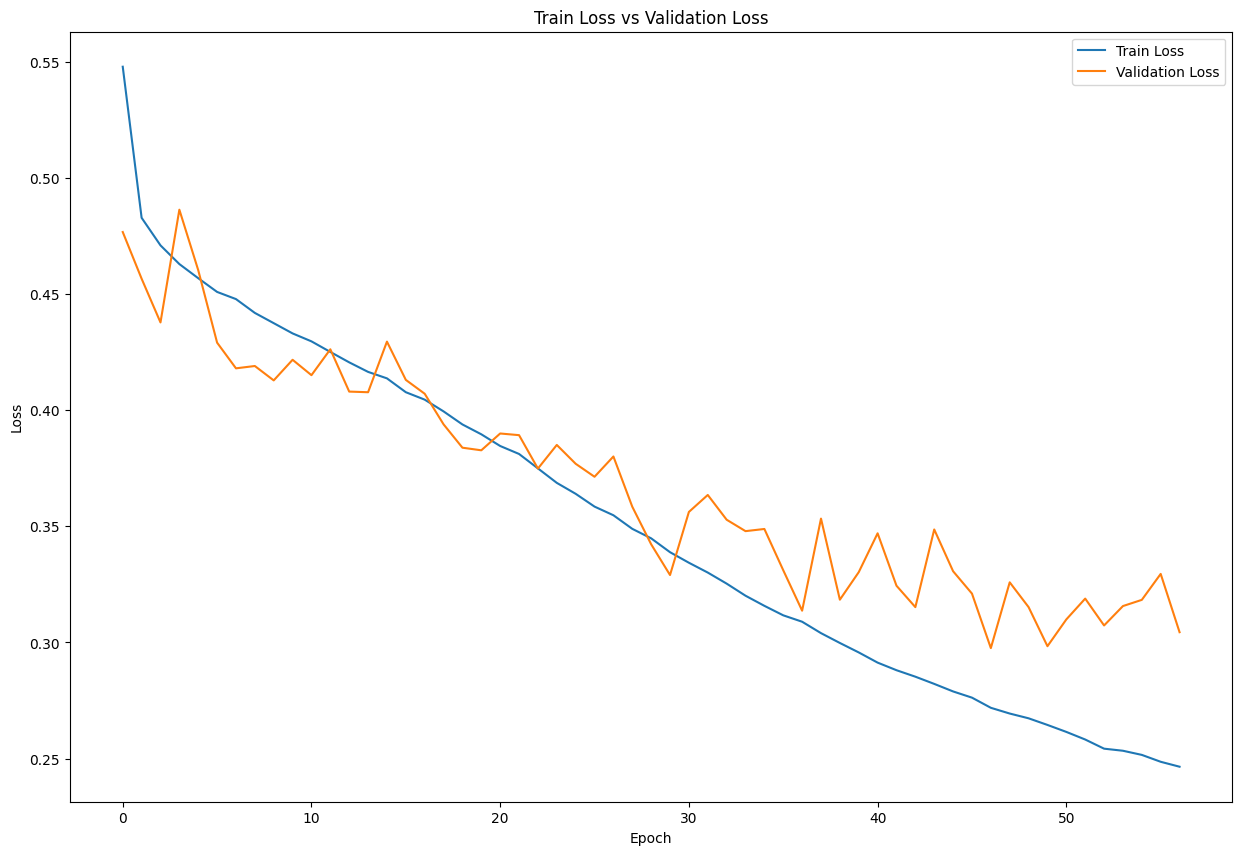

In [21]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train Loss vs Validation Loss")
plt.legend()
plt.show()

### Evaluation

In [18]:
model.load_state_dict(torch.load('./.export/checkpoint-aug-tf.pt'))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_25620\2047877440.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./.export/checkpoint-aug-tf

<All keys matched successfully>

In [19]:
def rmse(pred, target):
    return np.sqrt(np.mean((pred - target)**2))

def mae(pred, target):
    return np.mean(np.abs(pred - target))

def mard(pred, target):
    return np.mean(np.abs(pred - target) / (np.abs(target) + 1e-6))

def mbe(pred, target):
    return np.mean(pred - target)

def mape(pred, target):
    return np.mean(np.abs((target - pred) / (target + 1e-6))) * 100

def pearson_r(pred, target):
    return np.corrcoef(pred, target)[0, 1]

def ccc(pred, target):
    pred_mean = np.mean(pred)
    target_mean = np.mean(target)
    pred_var = np.var(pred)
    target_var = np.var(target)
    covariance = np.mean((pred - pred_mean) * (target - target_mean))
    return (2 * covariance) / (pred_var + target_var + (pred_mean - target_mean)**2 + 1e-6)

In [20]:
model.eval()
preds = []
preds_targets = []

with torch.no_grad():
    for x_seq, targets in tqdm(test_loader, desc="Evaluation"):
        x_seq = x_seq.to(device)
        targets = targets.to(device)
        outputs = model(x_seq)
        preds.append(outputs.cpu().numpy())
        preds_targets.append(targets.cpu().numpy())
        
preds = np.concatenate(preds)
preds_targets = np.concatenate(preds_targets)

target_scaler = joblib.load('./.data/target_scaler_aug.pkl')
all_preds = target_scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
all_targets = target_scaler.inverse_transform(preds_targets.reshape(-1, 1)).flatten()

residuals = all_preds - all_targets

Evaluation: 100%|██████████| 139/139 [00:01<00:00, 79.44it/s] 


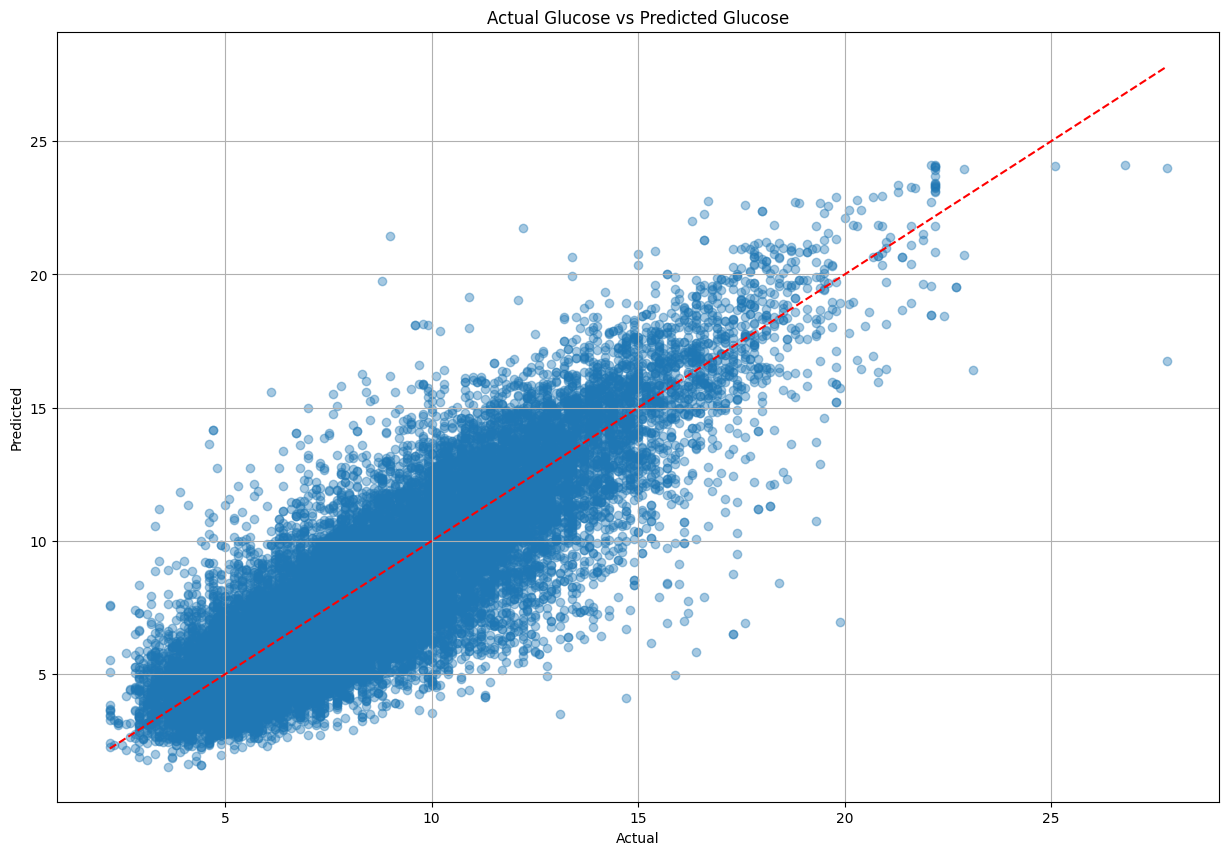

In [21]:
plt.figure(figsize=(15, 10))
plt.scatter(all_targets, all_preds, alpha=0.4)
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual Glucose vs Predicted Glucose")
plt.grid(True)
plt.show()

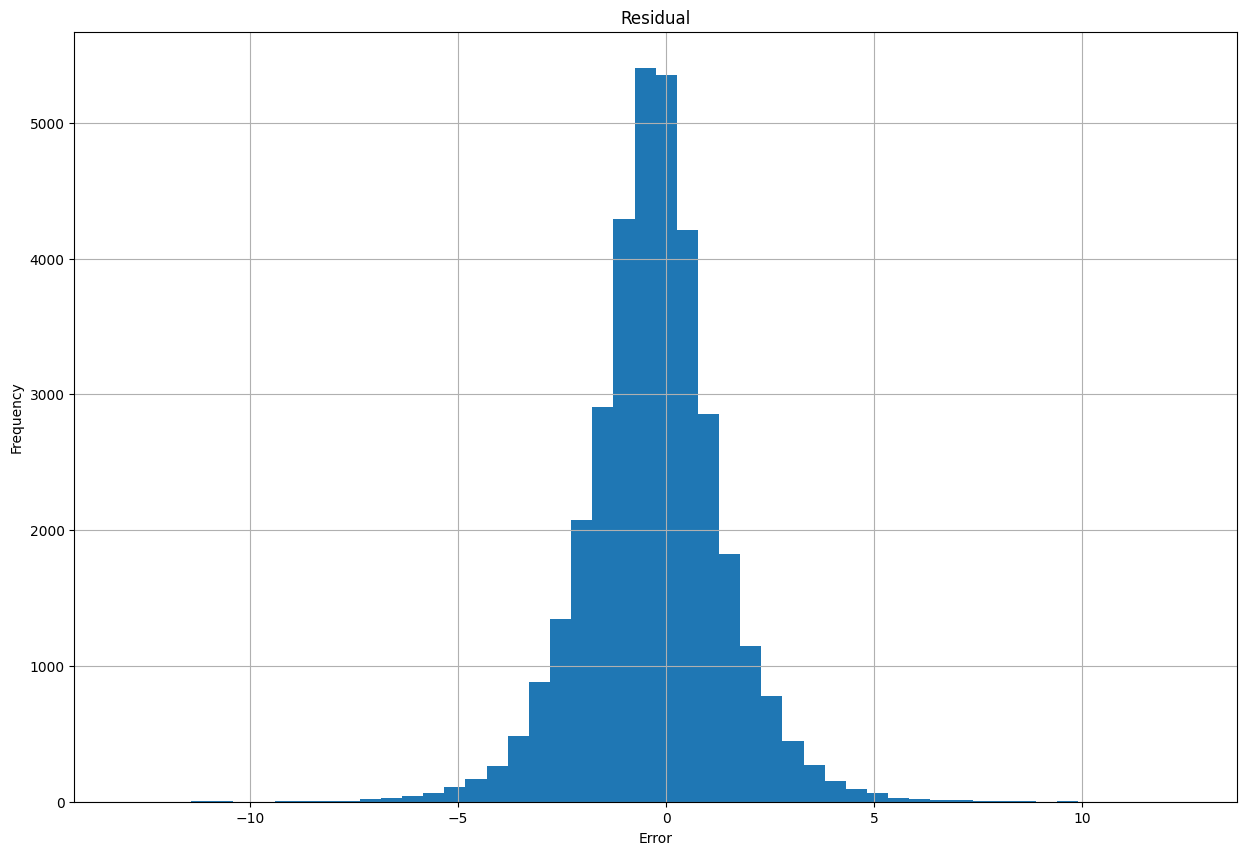

In [22]:
plt.figure(figsize=(15, 10))
plt.hist(residuals, bins=50)
plt.title("Residual")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [23]:
from sklearn.metrics import r2_score
test_r2 = r2_score(all_targets, all_preds)

In [24]:
from sklearn.metrics import explained_variance_score
test_expl_var = explained_variance_score(all_targets, all_preds)

In [25]:
test_rmse = rmse(all_preds, all_targets)
test_mae = mae(all_preds, all_targets)
test_mard = mard(all_preds, all_targets)

test_mbe = mbe(all_preds, all_targets)
test_r2 = r2_score(all_targets, all_preds)
test_expl_var = explained_variance_score(all_targets, all_preds)
test_mape = mape(all_preds, all_targets)
test_ccc = ccc(all_preds, all_targets)

In [26]:
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MSE: {test_rmse**2:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MARD: {test_mard:.4f}")
print(f"Test MBE: {test_mbe:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test Explained Variance: {test_expl_var:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Test CCC: {test_ccc:.4f}")

Test RMSE: 1.6668
Test MSE: 2.7781
Test MAE: 1.2382
Test MARD: 0.1570
Test MBE: -0.2987
Test R²: 0.6871
Test Explained Variance: 0.6971
Test MAPE: 15.70%
Test CCC: 0.8579


### Inference

In [32]:
df_test = pd.read_csv("./.data/test_aug.csv")

In [33]:
print(df_test)

            id   bg-1:55   bg-1:50   bg-1:45   bg-1:40   bg-1:35   bg-1:30  \
0     p01_8459  1.498370  1.484493  1.503679  1.531703  1.553799  1.622914   
1     p01_8460 -0.486487 -0.648439 -0.811465 -0.926369 -1.035974 -1.140981   
2     p01_8461 -1.101087 -1.091123 -1.083243 -1.078102 -1.066323 -1.050196   
3     p01_8462 -1.564556 -1.609264 -1.656996 -1.624340 -1.582254 -1.534382   
4     p01_8463 -1.443651 -1.533807 -1.626799 -1.664802 -1.693533 -1.715952   
...        ...       ...       ...       ...       ...       ...       ...   
3639   p24_256 -0.748448 -0.598134 -0.509490 -0.481286 -0.600973 -0.535748   
3640   p24_257 -0.839126 -0.598134 -0.388700 -0.329553 -0.297484 -0.354179   
3641   p24_258  0.339697  0.337539  0.305844  0.277379  0.218447  0.220792   
3642   p24_259 -0.476411 -0.477402 -0.479292 -0.450939 -0.388531 -0.354179   
3643   p24_260 -0.929805 -0.960330 -0.871860 -0.875791 -0.843764 -0.747580   

       bg-1:25   bg-1:20   bg-1:15  ...  cals-0:45  cals-0:40  

In [34]:
for col in df_test.columns:
    print(col)

id
bg-1:55
bg-1:50
bg-1:45
bg-1:40
bg-1:35
bg-1:30
bg-1:25
bg-1:20
bg-1:15
bg-1:10
bg-1:05
bg-1:00
bg-0:55
bg-0:50
bg-0:45
bg-0:40
bg-0:35
bg-0:30
bg-0:25
bg-0:20
bg-0:15
bg-0:10
bg-0:05
bg-0:00
insulin-1:55
insulin-1:50
insulin-1:45
insulin-1:40
insulin-1:35
insulin-1:30
insulin-1:25
insulin-1:20
insulin-1:15
insulin-1:10
insulin-1:05
insulin-1:00
insulin-0:55
insulin-0:50
insulin-0:45
insulin-0:40
insulin-0:35
insulin-0:30
insulin-0:25
insulin-0:20
insulin-0:15
insulin-0:10
insulin-0:05
insulin-0:00
carbs-1:55
carbs-1:50
carbs-1:45
carbs-1:40
carbs-1:35
carbs-1:30
carbs-1:25
carbs-1:20
carbs-1:15
carbs-1:10
carbs-1:05
carbs-1:00
carbs-0:55
carbs-0:50
carbs-0:45
carbs-0:40
carbs-0:35
carbs-0:30
carbs-0:25
carbs-0:20
carbs-0:15
carbs-0:10
carbs-0:05
carbs-0:00
hr-1:55
hr-1:50
hr-1:45
hr-1:40
hr-1:35
hr-1:30
hr-1:25
hr-1:20
hr-1:15
hr-1:10
hr-1:05
hr-1:00
hr-0:55
hr-0:50
hr-0:45
hr-0:40
hr-0:35
hr-0:30
hr-0:25
hr-0:20
hr-0:15
hr-0:10
hr-0:05
hr-0:00
steps-1:55
steps-1:50
steps-1:45
step

In [35]:
meta_data = ['id']
df_test_meta = df_test[meta_data]
df_test.drop(columns=meta_data, inplace=True)

In [36]:
infer_test_dataset = BrisT1DDataset(df_test, is_train=False)
infer_test_loader = DataLoader(infer_test_dataset, batch_size=256, shuffle=False)

In [37]:
model.load_state_dict(torch.load('./.export/checkpoint-aug-tf.pt'))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_37380\2047877440.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./.export/checkpoint-aug-tf

<All keys matched successfully>

In [38]:
model.eval()

all_preds = []
with torch.no_grad():
    for x_seq in tqdm(infer_test_loader, desc="Inference"):
        x_seq = x_seq.to(device)
        outputs = model(x_seq)
        all_preds.append(outputs.cpu().numpy())

all_preds = np.concatenate(all_preds)

Inference: 100%|██████████| 15/15 [00:00<00:00, 52.97it/s]


In [ ]:
target_scaler = joblib.load('./.data/target_scaler_aug.pkl')
all_preds_original = target_scaler.inverse_transform(all_preds.reshape(-1, 1)).flatten()

df_predictions = pd.DataFrame(all_preds_original, columns=["bg+1:00"])
df_results = pd.concat([df_test_meta.reset_index(drop=True), df_predictions], axis=1)
df_results.to_csv("./.export/test_submission_aug_tf.csv", index=False)

### Submission

In [1]:
!kaggle competitions submit -c brist1d -f ./.export/test_submission_aug_tf.csv -m "BrisT1D Submission: Transformer"

Successfully submitted to BrisT1D Blood Glucose Prediction Competition



  0%|          | 0.00/68.1k [00:00<?, ?B/s]
100%|██████████| 68.1k/68.1k [00:00<00:00, 76.9kB/s]


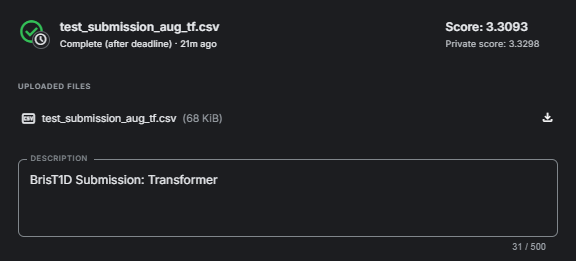

In [4]:
display(Image(filename='./.export/test_submission_aug_tf.png'))